# Обработка одного изображения

## Цель работы:

На произвольной картинке выполнить одно или несколько следующих преобразований:
1. Поиск границ.
2. Поиск примитивов. Преобразование Хафа
3. Поиск примитивов. Детектор Харриса
4. Сегментация изображения (метод К-средних)

## Ход работы

Подключаем необходимые библиотеки

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

Считываем изображение

In [4]:
img = cv2.imread('images/house.jpg')

In [5]:
img.shape

(572, 838, 3)

In [6]:
img_copy = np.copy(img)

In [7]:
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

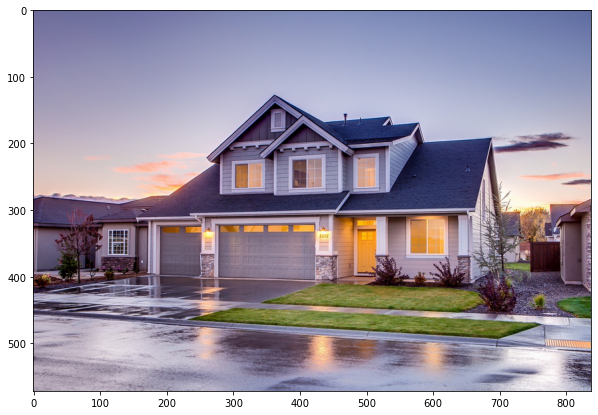

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(img_copy)

### Предобработка изображения

Конвертируем в оттенки серого

In [9]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [10]:
img_gray

array([[113, 112, 112, ..., 109, 109, 108],
       [114, 113, 112, ..., 109, 109, 109],
       [114, 113, 113, ..., 110, 109, 109],
       ...,
       [168, 166, 168, ..., 175, 176, 172],
       [167, 166, 167, ..., 157, 176, 171],
       [155, 159, 149, ..., 190, 173, 179]], dtype=uint8)

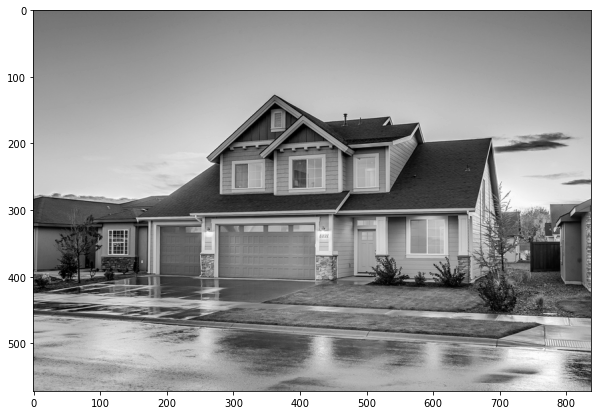

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(img_gray, cmap='gray')

Удаляем шум с помощью фильтра Гаусса

In [12]:
img_blur = cv2.GaussianBlur(img_gray, (5,5), 0)

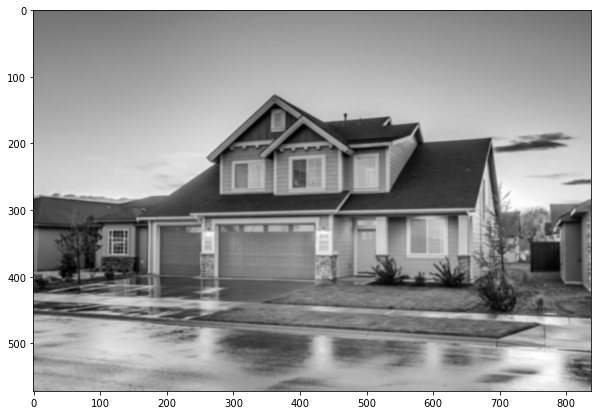

In [13]:
plt.figure(figsize = (10,10))
plt.imshow(img_blur, cmap='gray')

### 1. Поиск границ (Оператор Собеля)

Применим оператор Собеля по осям X, Y и комбинированный по XY

Оператор Собеля по оси X

\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1
\end{bmatrix}

In [14]:
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)

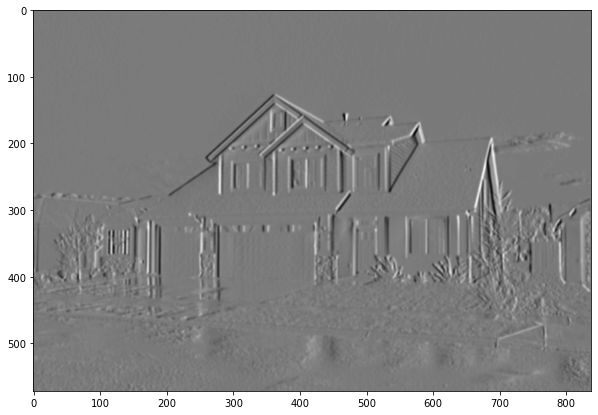

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(sobelx, cmap='gray')

Оператор Собеля по оси Y

\begin{bmatrix}
+1 & +2 & +1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}

In [16]:
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)

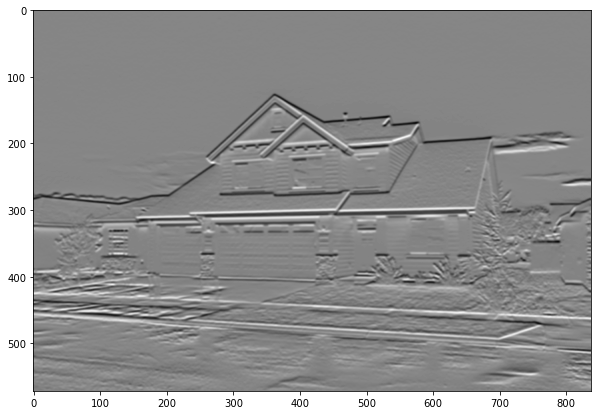

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(sobely, cmap='gray')

Комбинированный оператор Собеля по осям XY

In [18]:
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)

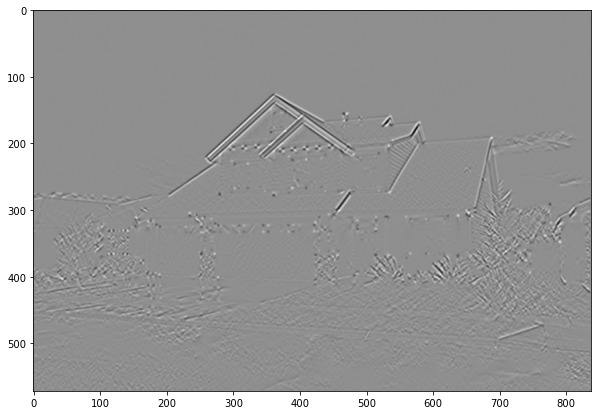

In [19]:
plt.figure(figsize = (10,10))
plt.imshow(sobelxy, cmap='gray')

### 2. Поиск примитивов. Преобразование Хафа

Преобразование Хафа (Hough Transform) — это метод для поиска линий, кругов и других простых форм на изображении.

Преобразование Хафа основывается на представлении искомого объекта в виде параметрического уравнения. Параметры этого уравнения представляют фазовое пространство (т.н. аккумуляторный массив/пространство, пространство Хафа).
Затем, берётся двоичное изображение (например, результат работы детектора границ Кенни). Перебираются все точки границ и делается предположение, что точка принадлежит линии искомого объекта — т.о. для каждой точки изображения рассчитывается нужное уравнение и получаются необходимые параметры, которые сохраняются в пространстве Хафа.
Финальным шагом является обход пространства Хафа и выбор максимальных значений, за которые «проголосовало» больше всего пикселей картинки, что и даёт нам параметры для уравнений искомого объекта.

Найдём границы с помощью детектора границ Кенни.

In [20]:
edges = cv2.Canny(img_blur, 150, 200)

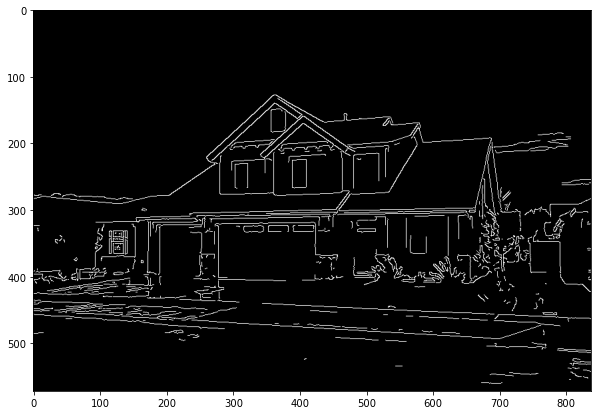

In [21]:
plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')

Найдём точки, формирующие линии, применив преобразование Хафа. Оно возвращает массив, который содержит подмассивы, содержащие 4 значения (x1, y1, x2, y2) каждый, то есть начальные и конечные координаты обнаруженных строк.

In [22]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 120, minLineLength=10, maxLineGap=250)

In [23]:
img_copy = np.copy(img)

В цикле отображаем найденные линии на исходном изображении

In [24]:
for line in lines:
     x1,y1,x2,y2 = line[0]
     cv2.line(img_copy, (x1,y1), (x2,y2), (0,255,0), 2)

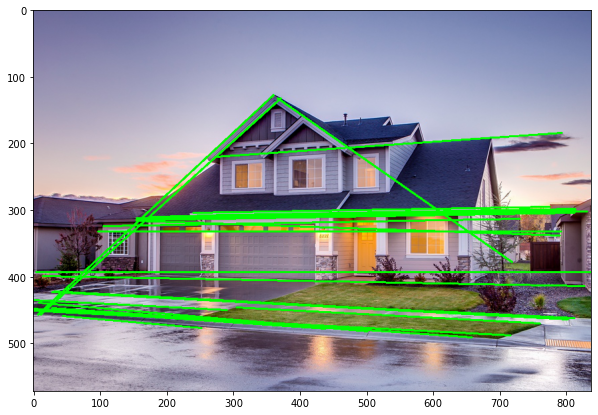

In [25]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

### 3. Поиск примитивов. Детектор Харриса

#### Обнаружение углов

Конвертация в оттенки серого

In [26]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

Обнаружение углов с помощью детектора Харриса

In [27]:
dst = cv2.cornerHarris(gray, 2, 5, 0.04)

Расширение углового изображения для улучшения угловых точек

In [28]:
dst = cv2.dilate(dst, None)

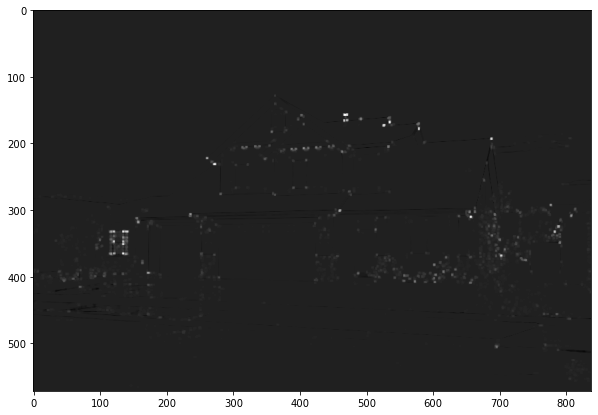

In [29]:
plt.figure(figsize = (10,10))
plt.imshow(dst, cmap='gray')

#### Извлечение и вывод сильных углов

Пороговое значение

In [30]:
thresh = 0.1*dst.max()

Делаем копию изображения для того, чтобы нарисовать на нём углы

In [31]:
corner_image = np.copy(img)

Перебираем все углы и рисуем их на изображении (если они прошли порог)

In [32]:
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > thresh):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

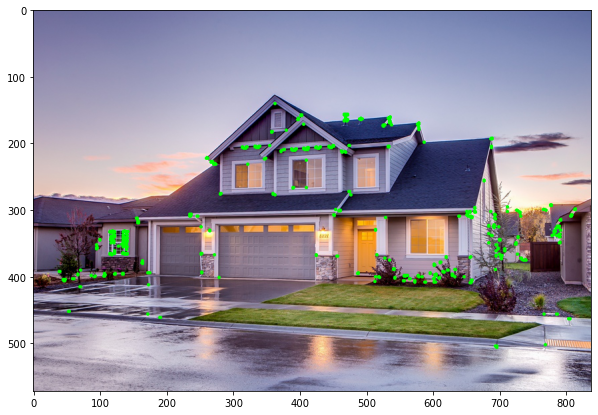

In [33]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))

### 4. Сегментация изображения (метод К-средних)

Сегментация изображений - это процесс разделения изображений на сегменты на основе характеристик пикселей. Это помогает нам анализировать и понимать изображения более осмысленно.

Кластеризация K-means - это метод, который кластеризует точки данных или векторы относительно ближайших средних точек, что приводит к разбиению точек данных или векторов на ячейки Вороного. Когда мы применяем алгоритм кластеризации k-means к изображению, он рассматривает каждый пиксель как точку вектора и строит k-кластеры пикселей.

Алгоритм кластеризации представлен ниже:

1. Выберите количество кластеров (K)
2. Инициализируйте K-средних со случайными пикселями - центроидами (не обязательно из заданного набора данных)
3. Повторять шаги 4 и 5 до сходимости или до окончания фиксированного числа итераций
4. для каждого пикселя $P_i$:
 * Найти ближайший центроид
 * Присвоить пиксели этому кластеру
5. для каждого кластера $C_i$
 * центроид = среднее значение всех точек, отнесенных к данному кластеру

In [59]:
img_copy = np.copy(img)

In [60]:
img_copy.shape

(572, 838, 3)

Конвертируем в RGB

In [61]:
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

Далее, преобразуем изображение $M \times N \times 3$ в матрицу $K \times 3$, где $K = M \times N$ и каждая строка теперь является вектором в трехмерном пространстве RGB.

In [62]:
vectorized = img.reshape((-1,3))

In [63]:
vectorized.shape

(479336, 3)

Преобразуем значения unit8 в float, поскольку это требование метода k-means в OpenCV.

In [64]:
vectorized = np.float32(vectorized)

Выберем количество кластеров K

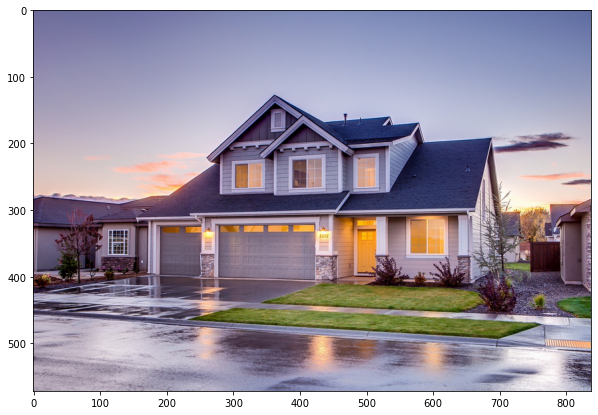

In [65]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Установим значение $k = 4$, так как на изображении выше можно увидеть небо, дом, траву и дорогу

OpenCV предоставляет функцию `cv2.kmeans(samples, nclusters(K), criteria, attempts, flags)` для кластеризации цветов.

Параметры функции:
1. `samples`: Выборка должна иметь тип данных np.float32, и каждая характеристика должна быть помещена в один столбец.

2. `nclusters(K)`: Количество кластеров, необходимых в конце.

3. `criteria`: Это критерий окончания итерации. Когда этот критерий удовлетворяется, итерация алгоритма прекращается. На самом деле, это должен быть кортеж из 3 параметров вида `( type, max_iter, epsilon )`:
Тип критерия завершения. Он имеет 3 флага, как показано ниже:

 * `cv.TERM_CRITERIA_EPS` - остановить итерацию алгоритма при достижении заданной точности, epsilon.
 * `cv.TERM_CRITERIA_MAX_ITER` - остановить алгоритм после указанного количества итераций, max_iter.
 * `cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER` - остановка итерации при выполнении любого из вышеперечисленных условий.
4. `attempts`: Флаг для указания количества попыток выполнения алгоритма с использованием различных начальных меток. Алгоритм возвращает метки, которые дают наилучшую компактность. Эта компактность возвращается как выход.

5. `flags`: Этот флаг используется для указания того, как берутся начальные центры. Обычно для этого используются два флага: `cv.KMEANS_PP_CENTERS` и `cv.KMEANS_RANDOM_CENTERS`.

Зададим критерий окончания итерации, количество кластеров и попыток

In [66]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [77]:
K = 4
attempts=10

Кластеризуем изображение с заданными параметрами

In [79]:
ret, label, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

Конвертируем обратно в uint8

In [80]:
center = np.uint8(center)

Далее получаем доступ к меткам для регенерации кластеризованного изображения

In [81]:
res = center[label.flatten()]
result_image = res.reshape((img.shape))

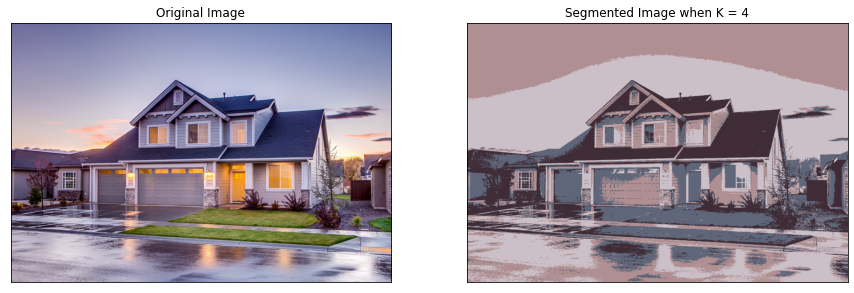

In [82]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K)
plt.xticks([])
plt.yticks([])
plt.show()

### Выводы

Изучены методы обработки изображений с помощью библиотеки OpenCV. Изучены методы извлечения признаков из изображений: поиск границ (оператор Собеля), поиск линий (преобразование Хафа, поиск углов, сегментация